# ⭐️ Blood Demand Forecasting

## 0. Data Details

* **Datetime:**
    * Date → วันที่

* **Blood Usage**
    * RBCs_Issued → จำนวนถุงเม็ดเลือดแดง (Red Blood Cells) ที่จ่ายออกไป (หน่วย: ถุง/วัน)
	* Platelets_Issued → จำนวนถุงเกล็ดเลือด (Platelets) ที่จ่ายออกไป
    * Plasma_Issued → จำนวนถุงพลาสมา (Plasma) ที่จ่ายออกไป

* **Patient Admit**
    * ICU → จำนวนผู้ป่วยที่เข้ารับการรักษาใน ICU
	* ER → Emergency Patients
	* Oncology → Cancer Patients
	* Surgery → จำนวนผู้ป่วยในแผนกผ่าตัด

* **Surgery Case**
	* Cardiac → จำนวนการผ่าตัดหัวใจ
	* Transplant → จำนวนการผ่าตัดปลูกถ่ายอวัยวะ
	* Trauma → จำนวนการผ่าตัดผู้ป่วยอุบัติเหตุ/ฉุกเฉิน

* **BloodGroup**
	* BloodGroup → "O+", "A+", "B+", "AB+", "O-", "A-", "B-", "AB-"





### Note Info

* Trauma massive bleed:
	* RBC : Plasma : Platelets
	* ≈ 1 : 1 : 1

* Cardiac / Transplant / major surgery bleed:
	* RBC : Plasma : Platelets
	* ≈ 2-3 : 1 : 1

* Elective surgery / non‐major bleed:
	* RBC : Plasma : Platelets
	* ≈ 3-5 : ≤1 : ≤1 (Plasma/Platelets ถูกรวมเมื่อมีเหตุจำเป็น)

* ICU (non‐bleeding):
	* RBC : Plasma : Platelets
	* ≈ 5-10 : 1 : 0.5 หรือมากกว่า ขึ้นกับ lab / medication

* ER:
	* RBC : Plasma : Platelets
	* ≈ 1 : 1 : 1

* Oncology:
	* ใช้ส่วนประกอบเลือดขึ้นอยู่กับภาวะของผู้ป่วย โดยไม่มีสัดส่วนคงที่

## 1. Set Mock Data

In [4]:
import pandas as pd
import numpy as np
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import timedelta
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error ,r2_score
import lightgbm as lgb
import joblib
import shap
from scipy.stats import zscore
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from statsmodels.tsa.arima.model import ARIMA
import lightgbm as lgb
import xgboost as xgb
import joblib

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_row', None)
pd.set_option('display.max_columns', None)

In [5]:
import pandas as pd
import numpy as np

# ฟังก์ชันสร้างข้อมูลวันเดียว
def generate_blood_day(seed=42, blood_group="A+"):
    np.random.seed(seed)
    def rand_int(low, high):
        return np.random.randint(low, high+1)

    cardiac = rand_int(0,5)
    transplant = rand_int(0,3)
    trauma = rand_int(0,8)

    icu = rand_int(5,15)
    er = rand_int(10,25)
    oncology = rand_int(5,15)

    return {
        "RBCs_Issued": rand_int(20,80),
        "Platelets_Issued": rand_int(10,40),
        "Plasma_Issued": rand_int(15,60),
        "ICU": icu,
        "ER": er,
        "Oncology": oncology,
        "Surgery": cardiac + transplant + trauma,
        "Cardiac": cardiac,
        "Transplant": transplant,
        "Trauma": trauma,
        "Blood_Group": blood_group,
        "All_Patients": icu + er + oncology
    }

# กำหนด distribution ของ blood group
blood_groups = ["O+", "A+", "B+", "AB+", "O-", "A-", "B-", "AB-"]
weights = [0.37, 0.35, 0.10, 0.04, 0.03, 0.06, 0.03, 0.02]

n_days = 2000
np.random.seed(42)

# สุ่ม blood group สำหรับแต่ละวันตาม weight
blood_group_samples = np.random.choice(blood_groups, size=n_days, p=weights)

# สร้าง DataFrame
df_list = []
for i, bg in enumerate(blood_group_samples):
    day_data = generate_blood_day(seed=42+i, blood_group=bg)
    day_data["Date"] = pd.Timestamp("2020-01-01") + pd.Timedelta(days=i)
    df_list.append(day_data)

df = pd.DataFrame(df_list)

# เพิ่มคอลัมน์ปี เดือน วัน วันในสัปดาห์
df["year"] = df["Date"].dt.year
df["month"] = df["Date"].dt.month
df["day"] = df["Date"].dt.day
df["weekday"] = df["Date"].dt.day_name()

# ตรวจสอบจำนวนวันและ distribution

print("All_Patients distribution by Blood_Group (mean/total):")
print(df.groupby("Blood_Group")["All_Patients"].sum())

All_Patients distribution by Blood_Group (mean/total):
Blood_Group
A+     25897
A-      4440
AB+     2182
AB-     1666
B+      7883
B-      2315
O+     27886
O-      2611
Name: All_Patients, dtype: int64


## 2. Preprocess Data

In [6]:
df.head()

,RBCs_Issued,Platelets_Issued,Plasma_Issued,ICU,ER,Oncology,Surgery,Cardiac,Transplant,Trauma,Blood_Group,All_Patients,Date,year,month,day,weekday
0,38,32,25,9,16,14,10,3,0,7,A+,39,2020-01-01,2020,1,1,Wednesday
1,71,27,42,10,20,5,5,4,0,1,B-,35,2020-01-02,2020,1,2,Thursday
2,23,25,57,8,10,9,8,4,3,1,B+,27,2020-01-03,2020,1,3,Friday
3,55,14,30,5,25,10,8,3,2,3,A+,40,2020-01-04,2020,1,4,Saturday
4,38,21,44,9,20,8,14,5,1,8,O+,37,2020-01-05,2020,1,5,Sunday


### Check dtype

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   RBCs_Issued       2000 non-null   int64         
 1   Platelets_Issued  2000 non-null   int64         
 2   Plasma_Issued     2000 non-null   int64         
 3   ICU               2000 non-null   int64         
 4   ER                2000 non-null   int64         
 5   Oncology          2000 non-null   int64         
 6   Surgery           2000 non-null   int64         
 7   Cardiac           2000 non-null   int64         
 8   Transplant        2000 non-null   int64         
 9   Trauma            2000 non-null   int64         
 10  Blood_Group       2000 non-null   object        
 11  All_Patients      2000 non-null   int64         
 12  Date              2000 non-null   datetime64[ns]
 13  year              2000 non-null   int64         
 14  month             2000 n

In [8]:
df.columns

Index(['RBCs_Issued', 'Platelets_Issued', 'Plasma_Issued', 'ICU', 'ER',
       'Oncology', 'Surgery', 'Cardiac', 'Transplant', 'Trauma', 'Blood_Group',
       'All_Patients', 'Date', 'year', 'month', 'day', 'weekday'],
      dtype='object')

### Check shape

In [9]:
df.shape

(2000, 17)

### Check Duplicate

In [10]:
df.reset_index().duplicated().sum()

0

### Check Missing Value

In [11]:
df.isna().any()

RBCs_Issued         False
Platelets_Issued    False
Plasma_Issued       False
ICU                 False
ER                  False
Oncology            False
Surgery             False
Cardiac             False
Transplant          False
Trauma              False
Blood_Group         False
All_Patients        False
Date                False
year                False
month               False
day                 False
weekday             False
dtype: bool

In [12]:
df.describe(include='all').T

/var/folders/7t/3b3ftw4173nfsbh_5d5nj6mh0000gn/T/ipykernel_96344/377021028.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all').T


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
RBCs_Issued,2000.0,NaN,NaN,NaN,NaT,NaT,49.429,17.8245,20.0,34.0,50.0,65.0,80.0
Platelets_Issued,2000.0,NaN,NaN,NaN,NaT,NaT,24.916,8.939122,10.0,17.0,25.0,33.0,40.0
Plasma_Issued,2000.0,NaN,NaN,NaN,NaT,NaT,37.5005,13.117318,15.0,26.0,37.0,49.0,60.0
ICU,2000.0,NaN,NaN,NaN,NaT,NaT,10.0515,3.191385,5.0,7.0,10.0,13.0,15.0
ER,2000.0,NaN,NaN,NaN,NaT,NaT,17.3995,4.603748,10.0,13.0,17.0,21.0,25.0
Oncology,2000.0,NaN,NaN,NaN,NaT,NaT,9.989,3.147989,5.0,7.0,10.0,13.0,15.0
Surgery,2000.0,NaN,NaN,NaN,NaT,NaT,7.959,3.312976,0.0,6.0,8.0,10.0,16.0
Cardiac,2000.0,NaN,NaN,NaN,NaT,NaT,2.524,1.725953,0.0,1.0,2.0,4.0,5.0
Transplant,2000.0,NaN,NaN,NaN,NaT,NaT,1.53,1.107571,0.0,1.0,2.0,2.0,3.0
Trauma,2000.0,NaN,NaN,NaN,NaT,NaT,3.905,2.565398,0.0,2.0,4.0,6.0,8.0


## 3. EDA
* Plot Time series
* Decomposition (trend / seasonal / remainder) — ใช้ STL

* Seasonality: day-of-week boxplot, monthly patterns

* Autocorrelation (ACF, PACF) เพื่อตัดสิน lag ที่สำคัญ

* ความสัมพันธ์กับ exogenous (corr, scatter) เช่น ICU, Surgery, Trauma, BloodGroup_O+ ฯลฯ

* ตรวจ outliers และ change points (spikes ที่มาจากเหตุการณ์จริง — เก็บไว้หากเป็นจริง)

### Explore RBCs

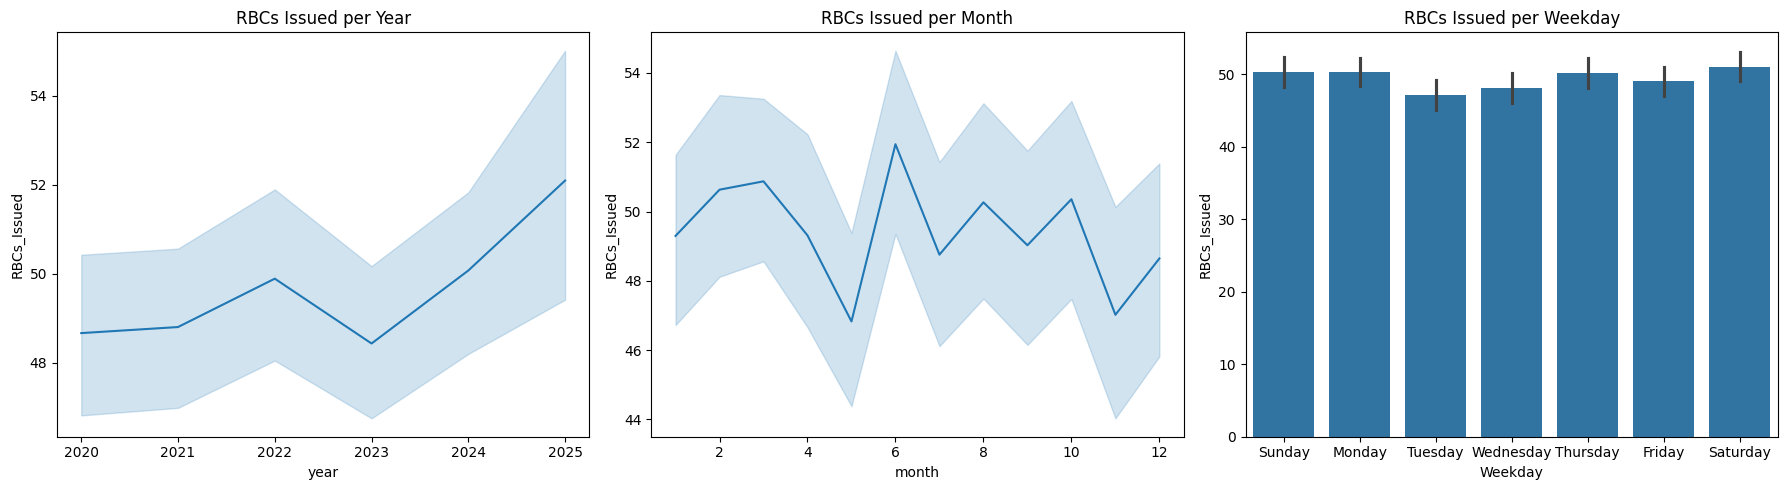

In [13]:
# กำหนดลำดับ weekday
weekday_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 แถว 3 คอลัมน์

# Plot 1: RBCs vs Year
sns.lineplot(x="year", y="RBCs_Issued", data=df, ax=axes[0])
axes[0].set_title("RBCs Issued per Year")

# Plot 2: RBCs vs Month
sns.lineplot(x="month", y="RBCs_Issued", data=df, ax=axes[1])
axes[1].set_title("RBCs Issued per Month")

# Plot 3: RBCs vs Weekday (เรียงลำดับ)
sns.barplot(x="weekday", y="RBCs_Issued", data=df, order=weekday_order, ax=axes[2])
axes[2].set_title("RBCs Issued per Weekday")
axes[2].set_xlabel("Weekday")
axes[2].set_ylabel("RBCs_Issued")

plt.tight_layout()
plt.show()

### Explore Platelets

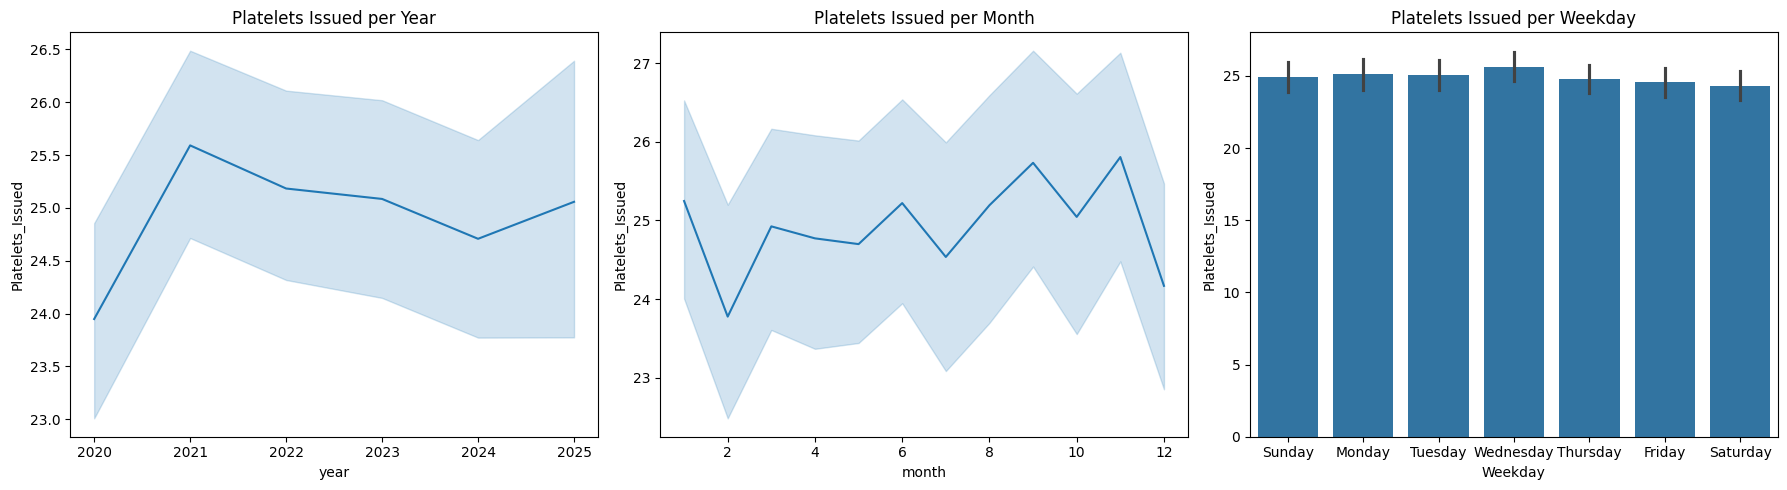

In [14]:
# กำหนดลำดับ weekday
weekday_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 แถว 3 คอลัมน์
# Plot 1: Platelets vs Year
sns.lineplot(x="year", y="Platelets_Issued", data=df, ax=axes[0])
axes[0].set_title("Platelets Issued per Year")

# Plot 2: Platelets vs Month
sns.lineplot(x="month", y="Platelets_Issued", data=df, ax=axes[1])
axes[1].set_title("Platelets Issued per Month")

# Plot 3: Platelets vs Weekday (เรียงลำดับ)
sns.barplot(x="weekday", y="Platelets_Issued", data=df, order=weekday_order, ax=axes[2])
axes[2].set_title("Platelets Issued per Weekday")
axes[2].set_xlabel("Weekday")
axes[2].set_ylabel("Platelets_Issued")

plt.tight_layout()
plt.show()

### Explore Plasma

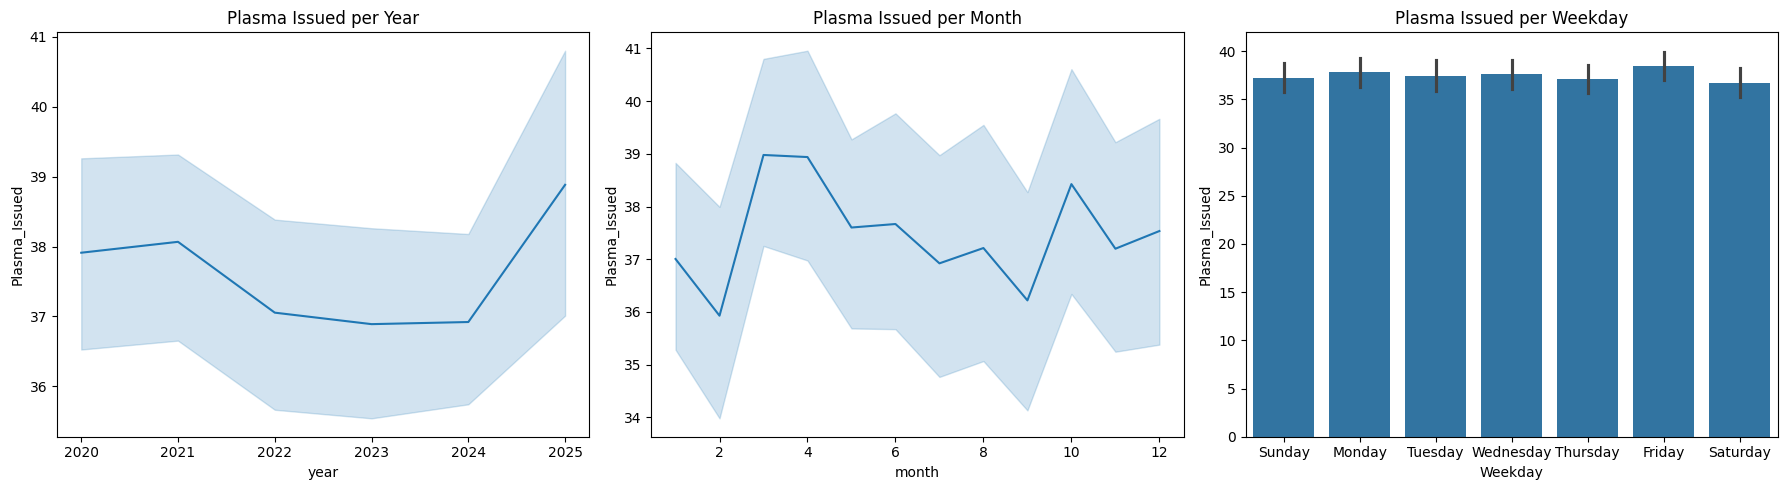

In [15]:
# กำหนดลำดับ weekday
weekday_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 แถว 3 คอลัมน์
# Plot 1: Plasma vs Year
sns.lineplot(x="year", y="Plasma_Issued", data=df, ax=axes[0])
axes[0].set_title("Plasma Issued per Year")

# Plot 2: Plasma vs Month
sns.lineplot(x="month", y="Plasma_Issued", data=df, ax=axes[1])
axes[1].set_title("Plasma Issued per Month")

# Plot 3: Plasma vs Weekday (เรียงลำดับ)
sns.barplot(x="weekday", y="Plasma_Issued", data=df, order=weekday_order, ax=axes[2])
axes[2].set_title("Plasma Issued per Weekday")
axes[2].set_xlabel("Weekday")
axes[2].set_ylabel("Plasma_Issued")

plt.tight_layout()
plt.show()

### Blood Group Distribution

In [16]:
exclude_cols = {"year", "month", "day", "weekday"}
numeric_cols = [c for c in df.select_dtypes(include=np.number).columns if c not in exclude_cols]

df.groupby(['year', 'Blood_Group'])[numeric_cols].sum().reset_index()

,year,Blood_Group,RBCs_Issued,Platelets_Issued,Plasma_Issued,ICU,ER,Oncology,Surgery,Cardiac,Transplant,Trauma,All_Patients
0,2020,A+,6123,3105,4874,1241,2249,1260,1045,322,189,534,4750
1,2020,A-,1255,580,1001,272,468,234,198,52,40,106,974
2,2020,AB+,547,201,278,89,168,102,73,21,13,39,359
3,2020,AB-,177,64,103,30,55,25,24,11,0,13,110
4,2020,B+,1644,823,1249,355,600,368,301,98,61,142,1323
5,2020,B-,596,369,535,131,235,115,111,36,19,56,481
6,2020,O+,7031,3412,5515,1475,2560,1433,1192,386,209,597,5468
7,2020,O-,440,211,321,97,173,82,64,15,13,36,352
8,2021,A+,5688,2973,4352,1220,1997,1124,884,268,178,438,4341
9,2021,A-,1206,661,932,260,429,237,209,67,37,105,926


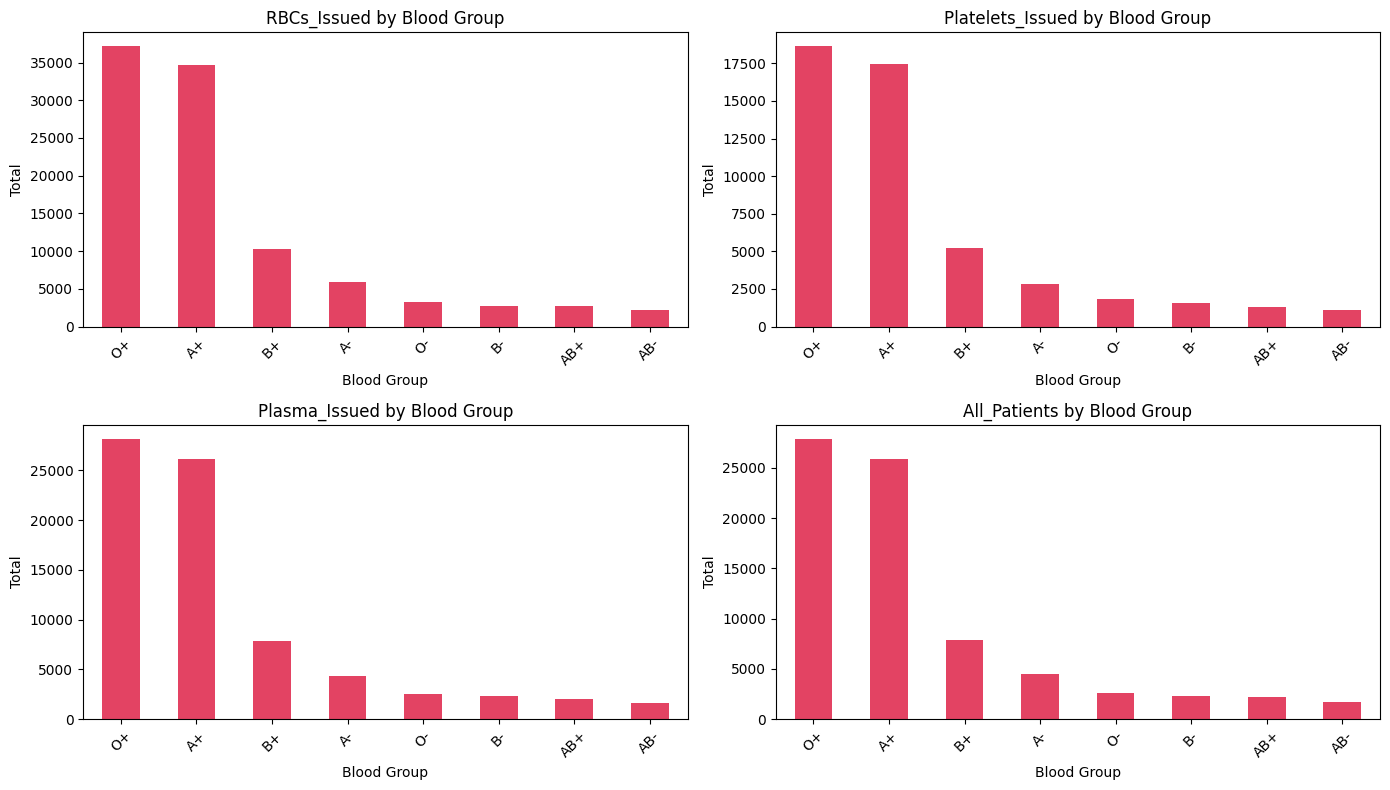

In [17]:

# columns ที่ต้องการ plot
columns_to_plot = [
    'RBCs_Issued', 'Platelets_Issued', 'Plasma_Issued', 'All_Patients'
]

# เตรียม figure
n_cols = 2  # number of columns in subplot
n_rows = (len(columns_to_plot) + n_cols - 1) // n_cols  # calculate rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows*4))
axes = axes.flatten()  # flatten in case of multiple rows

for i, col in enumerate(columns_to_plot):
    # group by Blood_Group แล้ว sum ค่า
    data = df.groupby('Blood_Group')[col].sum().sort_values(ascending=False)

    # plot bar chart
    data.plot(kind='bar', ax=axes[i], color='crimson', alpha=0.8)
    axes[i].set_title(f"{col} by Blood Group")
    axes[i].set_xlabel("Blood Group")
    axes[i].set_ylabel("Total")
    axes[i].tick_params(axis='x', rotation=45)

# hide any unused subplot axes
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### Patients Distributions

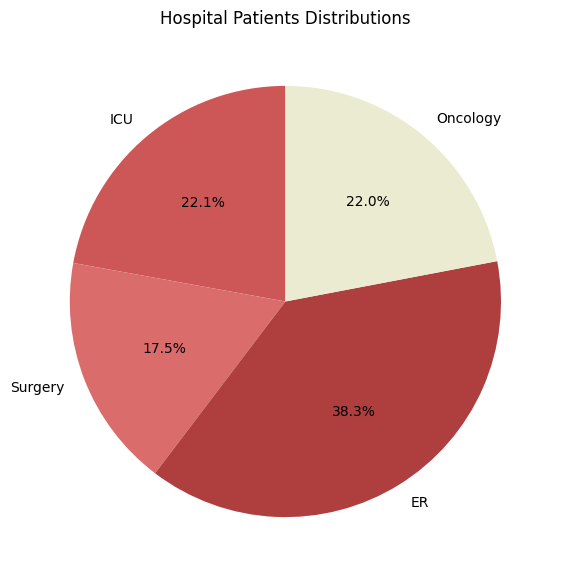

In [18]:
# รวมจำนวนผู้ป่วยแต่ละแผนก
icu_total = df["ICU"].sum()
surgery_total = df["Surgery"].sum()
er_total = df["ER"].sum()
oncology_total = df["Oncology"].sum()

# เตรียมข้อมูลสำหรับ pie chart
values = [icu_total, surgery_total, er_total, oncology_total]
labels = ["ICU", "Surgery", "ER", "Oncology"]
colors = ["#CD5656", "#DA6C6C", "#AF3E3E", "#EAEBD0"]

# Plot Pie Chart
plt.figure(figsize=(7,7))
plt.pie(values, labels=labels, autopct="%1.1f%%", startangle=90, colors=colors)
plt.title("Hospital Patients Distributions")
plt.show()

### Surgery Cases

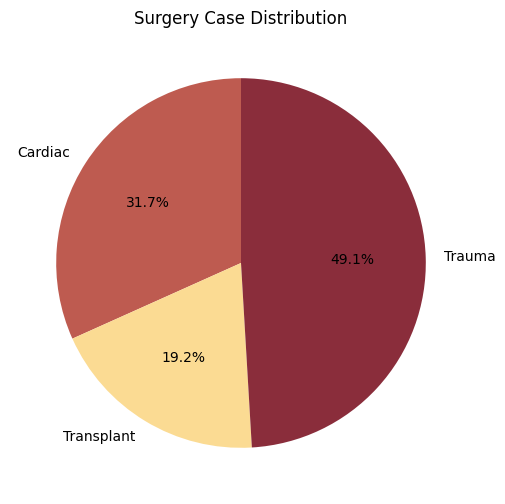

In [19]:
# รวมจำนวนเคสผ่าตัดแต่ละประเภท
cardiac_total = df["Cardiac"].sum()
transplant_total = df["Transplant"].sum()
trauma_total = df["Trauma"].sum()

# เตรียมข้อมูล
values = [cardiac_total, transplant_total, trauma_total]
labels = ["Cardiac", "Transplant", "Trauma"]

# Plot Pie Chart
plt.figure(figsize=(6,6))
plt.pie(values, labels=labels, autopct="%1.1f%%", startangle=90,
        colors=["#BE5B50","#FBDB93","#8A2D3B"])
plt.title("Surgery Case Distribution")
plt.show()

## 4. Cleaning


In [20]:
df.isna().any()

RBCs_Issued         False
Platelets_Issued    False
Plasma_Issued       False
ICU                 False
ER                  False
Oncology            False
Surgery             False
Cardiac             False
Transplant          False
Trauma              False
Blood_Group         False
All_Patients        False
Date                False
year                False
month               False
day                 False
weekday             False
dtype: bool

### Outlier check

#### IQR

In [21]:
Q1 = df['All_Patients'].quantile(0.25)
Q2 = df['All_Patients'].quantile(0.5)
Q3 = df['All_Patients'].quantile(0.75)
IQR = Q3 - Q1

outlier_cutoff = Q3 + 1.5 * IQR

df['is_outlier_IQR'] = df['All_Patients'] > outlier_cutoff
df[df['is_outlier_IQR'] == True].head()

,RBCs_Issued,Platelets_Issued,Plasma_Issued,ICU,ER,Oncology,Surgery,Cardiac,Transplant,Trauma,Blood_Group,All_Patients,Date,year,month,day,weekday,is_outlier_IQR


#### Z-score

In [22]:
# Z-score method
df['zscore'] = zscore(df['All_Patients'])

# กำหนด threshold -> |z| > 3
z_thresh = 3
df['is_outlier_z'] = df['zscore'].abs() > z_thresh

#### Rolling median

In [23]:
# Rolling median method
window = 7  # ขนาด rolling window (วัน)
rolling_median = df['All_Patients'].rolling(window, center=True).median()
rolling_std = df['All_Patients'].rolling(window, center=True).std()

# กำหนด threshold เป็น 3 * rolling std
df['is_outlier_rolling'] = (df['All_Patients'] - rolling_median).abs() > (3 * rolling_std)

#### Check outlier from all methods

In [24]:
df.loc[
    (df['is_outlier_rolling'] == True) |
    (df['is_outlier_z'] == True) |
    (df['is_outlier_IQR'] == True)
]

,RBCs_Issued,Platelets_Issued,Plasma_Issued,ICU,ER,Oncology,Surgery,Cardiac,Transplant,Trauma,Blood_Group,All_Patients,Date,year,month,day,weekday,is_outlier_IQR,zscore,is_outlier_z,is_outlier_rolling


## 5. Feature engineering

* Lag features: 1,2,3,7,14,28 days
* Rolling windows: mean/std/median of last 7/14/28 days (shifted)
* EWMA: exponential moving average

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   RBCs_Issued         2000 non-null   int64         
 1   Platelets_Issued    2000 non-null   int64         
 2   Plasma_Issued       2000 non-null   int64         
 3   ICU                 2000 non-null   int64         
 4   ER                  2000 non-null   int64         
 5   Oncology            2000 non-null   int64         
 6   Surgery             2000 non-null   int64         
 7   Cardiac             2000 non-null   int64         
 8   Transplant          2000 non-null   int64         
 9   Trauma              2000 non-null   int64         
 10  Blood_Group         2000 non-null   object        
 11  All_Patients        2000 non-null   int64         
 12  Date                2000 non-null   datetime64[ns]
 13  year                2000 non-null   int64       

In [26]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import Week
from itertools import product

def create_features(df):
    df = df.sort_values("Date").reset_index(drop=True)

    # US federal holidays example (change calendar if needed)
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=df['Date'].min(), end=df['Date'].max())
    df['is_holiday'] = df['Date'].isin(holidays).astype(int)

    # Lag Features
    lag_days = [1,2,3,7,14,28]
    numeric_cols = ['RBCs_Issued', 'Platelets_Issued', 'Plasma_Issued',
                    'ICU','ER','Oncology','Surgery','Cardiac','Transplant','Trauma','All_Patients']

    for col, lag in product(numeric_cols, lag_days):
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

    # Rolling Windows
    rolling_windows = [7,14,28]
    for col, w in product(numeric_cols, rolling_windows):
        df[f'{col}_rollmean{w}'] = df[col].shift(1).rolling(w).mean()
        df[f'{col}_rollstd{w}']  = df[col].shift(1).rolling(w).std()
        df[f'{col}_rollmedian{w}'] = df[col].shift(1).rolling(w).median()

    # EWMA
    alphas = [0.1, 0.3, 0.5]
    for col, alpha in product(numeric_cols, alphas):
        alpha_str = f"{alpha:.1f}".replace(".", "_")
        df[f'{col}_ewma_{alpha_str}'] = df[col].shift(1).ewm(alpha=alpha, adjust=False).mean()
    return df

df_fe = create_features(df)


/var/folders/7t/3b3ftw4173nfsbh_5d5nj6mh0000gn/T/ipykernel_96344/3862113839.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rollstd{w}']  = df[col].shift(1).rolling(w).std()
/var/folders/7t/3b3ftw4173nfsbh_5d5nj6mh0000gn/T/ipykernel_96344/3862113839.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rollmedian{w}'] = df[col].shift(1).rolling(w).median()
/var/folders/7t/3b3ftw4173nfsbh_5d5nj6mh0000gn/T/ipykernel_96344/3862113839.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usual

In [27]:
df_fe.head(30)

,RBCs_Issued,Platelets_Issued,Plasma_Issued,ICU,ER,Oncology,Surgery,Cardiac,Transplant,Trauma,Blood_Group,All_Patients,Date,year,month,day,weekday,is_outlier_IQR,zscore,is_outlier_z,is_outlier_rolling,is_holiday,RBCs_Issued_lag1,RBCs_Issued_lag2,RBCs_Issued_lag3,RBCs_Issued_lag7,RBCs_Issued_lag14,RBCs_Issued_lag28,Platelets_Issued_lag1,Platelets_Issued_lag2,Platelets_Issued_lag3,Platelets_Issued_lag7,Platelets_Issued_lag14,Platelets_Issued_lag28,Plasma_Issued_lag1,Plasma_Issued_lag2,Plasma_Issued_lag3,Plasma_Issued_lag7,Plasma_Issued_lag14,Plasma_Issued_lag28,ICU_lag1,ICU_lag2,ICU_lag3,ICU_lag7,ICU_lag14,ICU_lag28,ER_lag1,ER_lag2,ER_lag3,ER_lag7,ER_lag14,ER_lag28,Oncology_lag1,Oncology_lag2,Oncology_lag3,Oncology_lag7,Oncology_lag14,Oncology_lag28,Surgery_lag1,Surgery_lag2,Surgery_lag3,Surgery_lag7,Surgery_lag14,Surgery_lag28,Cardiac_lag1,Cardiac_lag2,Cardiac_lag3,Cardiac_lag7,Cardiac_lag14,Cardiac_lag28,Transplant_lag1,Transplant_lag2,Transplant_lag3,Transplant_lag7,Transplant_lag14,Transplant_lag28,Trauma_lag1,Trauma_lag2,Trauma_lag3,Trauma_lag7,Trauma_lag14,Trauma_lag28,All_Patients_lag1,All_Patients_lag2,All_Patients_lag3,All_Patients_lag7,All_Patients_lag14,All_Patients_lag28,RBCs_Issued_rollmean7,RBCs_Issued_rollstd7,RBCs_Issued_rollmedian7,RBCs_Issued_rollmean14,RBCs_Issued_rollstd14,RBCs_Issued_rollmedian14,RBCs_Issued_rollmean28,RBCs_Issued_rollstd28,RBCs_Issued_rollmedian28,Platelets_Issued_rollmean7,Platelets_Issued_rollstd7,Platelets_Issued_rollmedian7,Platelets_Issued_rollmean14,Platelets_Issued_rollstd14,Platelets_Issued_rollmedian14,Platelets_Issued_rollmean28,Platelets_Issued_rollstd28,Platelets_Issued_rollmedian28,Plasma_Issued_rollmean7,Plasma_Issued_rollstd7,Plasma_Issued_rollmedian7,Plasma_Issued_rollmean14,Plasma_Issued_rollstd14,Plasma_Issued_rollmedian14,Plasma_Issued_rollmean28,Plasma_Issued_rollstd28,Plasma_Issued_rollmedian28,ICU_rollmean7,ICU_rollstd7,ICU_rollmedian7,ICU_rollmean14,ICU_rollstd14,ICU_rollmedian14,ICU_rollmean28,ICU_rollstd28,ICU_rollmedian28,ER_rollmean7,ER_rollstd7,ER_rollmedian7,ER_rollmean14,ER_rollstd14,ER_rollmedian14,ER_rollmean28,ER_rollstd28,ER_rollmedian28,Oncology_rollmean7,Oncology_rollstd7,Oncology_rollmedian7,Oncology_rollmean14,Oncology_rollstd14,Oncology_rollmedian14,Oncology_rollmean28,Oncology_rollstd28,Oncology_rollmedian28,Surgery_rollmean7,Surgery_rollstd7,Surgery_rollmedian7,Surgery_rollmean14,Surgery_rollstd14,Surgery_rollmedian14,Surgery_rollmean28,Surgery_rollstd28,Surgery_rollmedian28,Cardiac_rollmean7,Cardiac_rollstd7,Cardiac_rollmedian7,Cardiac_rollmean14,Cardiac_rollstd14,Cardiac_rollmedian14,Cardiac_rollmean28,Cardiac_rollstd28,Cardiac_rollmedian28,Transplant_rollmean7,Transplant_rollstd7,Transplant_rollmedian7,Transplant_rollmean14,Transplant_rollstd14,Transplant_rollmedian14,Transplant_rollmean28,Transplant_rollstd28,Transplant_rollmedian28,Trauma_rollmean7,Trauma_rollstd7,Trauma_rollmedian7,Trauma_rollmean14,Trauma_rollstd14,Trauma_rollmedian14,Trauma_rollmean28,Trauma_rollstd28,Trauma_rollmedian28,All_Patients_rollmean7,All_Patients_rollstd7,All_Patients_rollmedian7,All_Patients_rollmean14,All_Patients_rollstd14,All_Patients_rollmedian14,All_Patients_rollmean28,All_Patients_rollstd28,All_Patients_rollmedian28,RBCs_Issued_ewma_0_1,RBCs_Issued_ewma_0_3,RBCs_Issued_ewma_0_5,Platelets_Issued_ewma_0_1,Platelets_Issued_ewma_0_3,Platelets_Issued_ewma_0_5,Plasma_Issued_ewma_0_1,Plasma_Issued_ewma_0_3,Plasma_Issued_ewma_0_5,ICU_ewma_0_1,ICU_ewma_0_3,ICU_ewma_0_5,ER_ewma_0_1,ER_ewma_0_3,ER_ewma_0_5,Oncology_ewma_0_1,Oncology_ewma_0_3,Oncology_ewma_0_5,Surgery_ewma_0_1,Surgery_ewma_0_3,Surgery_ewma_0_5,Cardiac_ewma_0_1,Cardiac_ewma_0_3,Cardiac_ewma_0_5,Transplant_ewma_0_1,Transplant_ewma_0_3,Transplant_ewma_0_5,Trauma_ewma_0_1,Trauma_ewma_0_3,Trauma_ewma_0_5,All_Patients_ewma_0_1,All_Patients_ewma_0_3,All_Patients_ewma_0_5
0,38,32,25,9,16,14,10,3,0,7,A+,39,2020-01-01,2020,1,1,Wednesday,False,0.245996,False,False,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [28]:
df_fe.shape

(2000, 220)

## 6. Baseline models
* Naive: forecast = last observed value
* Seasonal naive: forecast = value same weekday last week

In [29]:
df_fe = df_fe.sort_values("Date").reset_index(drop=True)

# Naive Forecast
df_fe['forecast_naive'] = df_fe['All_Patients'].shift(1) # last observed value

# Seasonal Naive Forecast
df_fe['forecast_seasonal_naive'] = df_fe['All_Patients'].shift(7) # value same weekday last week (7 days ago)

df_fe[['Date', 'All_Patients', 'forecast_naive', 'forecast_seasonal_naive']].head(15)

,Date,All_Patients,forecast_naive,forecast_seasonal_naive
0,2020-01-01,39,NaN,NaN
1,2020-01-02,35,39.0,NaN
2,2020-01-03,27,35.0,NaN
3,2020-01-04,40,27.0,NaN
4,2020-01-05,37,40.0,NaN
5,2020-01-06,27,37.0,NaN
6,2020-01-07,35,27.0,NaN
7,2020-01-08,35,35.0,39.0
8,2020-01-09,35,35.0,35.0
9,2020-01-10,34,35.0,27.0


## 7. Modeling

* Linear Regression
* SARIMAX (interpretability, intervals)
* LightGBM (feature-based tree model — ชอบเวลามี many exogs)
	* สร้าง X,y จาก features (lag + exogs), ใช้ TimeSeriesSplit หรือ manual expanding CV
	* ใช้ LGBMRegressor หรือ lgb.train พร้อม early stopping

* XGBoost ใช้ forecast residuals ของ STL

### Linear Regression (RBCs_Issued)

#### Prepare data before fitting it into the model

In [30]:
target = "RBCs_Issued"

drop_cols = ["Date", "Blood_Group", target]

feature_cols = [
    # Base patient counts
    "ICU", "ER", "Oncology", "Surgery", "Cardiac", "Transplant", "Trauma", "All_Patients",

    # Time features
    "year", "month",

    # Lag features
    "RBCs_Issued_lag1", "RBCs_Issued_lag7", "RBCs_Issued_lag14",

    # Rolling mean & std
    "RBCs_Issued_rollmean7", "RBCs_Issued_rollstd7",
    "RBCs_Issued_rollmean14", "RBCs_Issued_rollstd14",

    # EWMA (เลือก decay เดียว)
    "RBCs_Issued_ewma_0_1","RBCs_Issued_ewma_0_3","RBCs_Issued_ewma_0_5",

    # Baseline forecast
    "forecast_naive", "forecast_seasonal_naive"
]

def prepare_data(df, target, feature_cols, test_size=0.3, impute_strategy="mean"):
    # Impute missing values
    imputer = SimpleImputer(strategy=impute_strategy)
    X = imputer.fit_transform(df[feature_cols])
    y = df[target].values

    # Holdout split (last k days for test)
    k = int(test_size * len(df))
    X_train, X_test = X[:-k], X[-k:]
    y_train, y_test = y[:-k], y[-k:]

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = prepare_data(df_fe, target, feature_cols)


#### Model and Fit

In [31]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

#### Prediction

In [32]:
y_pred = linear_model.predict(X_test)

#### Evaluate Model

In [33]:
def evaluate(y_true, y_pred, name="Model"):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name}: \nRMSE= {rmse:.4f} \nMAE= {mae:.4f} \nR2= {r2:.4f}")
    return rmse, mae, r2

linear_rmse, linear_mae, linear_r2 = evaluate(y_test, y_pred, name="Linear Regrssion")

Linear Regrssion: 
RMSE= 17.9900 
MAE= 15.7527 
R2= -0.0186


#### Coef

In [34]:
coef_df = pd.DataFrame({
    "Feature": feature_cols,
    "Coefficient": linear_model.coef_
}).sort_values(by="Coefficient", ascending=False)

coef_df.head(20)

,Feature,Coefficient
1,ER,8.515204e+12
2,Oncology,8.515204e+12
0,ICU,8.515204e+12
6,Trauma,1.528322e+10
4,Cardiac,1.528322e+10
5,Transplant,1.528322e+10
14,RBCs_Issued_rollstd7,3.587470e-01
21,forecast_seasonal_naive,1.242900e-01
19,RBCs_Issued_ewma_0_5,8.092419e-02
20,forecast_naive,5.656491e-02


### ARIMA (RBCs_Issued)

#### Prepare data before fitting it into the model

In [35]:
y = df_fe.set_index("Date")["RBCs_Issued"]

k = int(0.7 * len(y))       # จำนวนวันคิดเป็น 70% ของทั้งหมด
train = y.iloc[:k].copy()   # train 70
test = y.iloc[k:].copy()    # test 30



#### Model and Fit

In [36]:
arima_model = ARIMA(
    train,
    order=(1,2,2),              # (p, d, q)
    enforce_stationarity=False,
    enforce_invertibility=False
)

res = arima_model.fit()

print(res.summary())

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            RBCs_Issued   No. Observations:                 1400
Model:                 ARIMA(1, 2, 2)   Log Likelihood               -6089.791
Date:                Thu, 25 Sep 2025   AIC                          12187.583
Time:                        13:55:24   BIC                          12208.545
Sample:                    01-01-2020   HQIC                         12195.420
                         - 10-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0582      0.046      1.269      0.204      -0.032       0.148
ma.L1         -1.9942      0.008   -243.893      0.000      -2.010      -1.978
ma.L2          0.9942      0.008    121.745      0.0

#### Prediction

In [37]:
forecast_res = res.get_forecast(steps=len(test))
conf_int = forecast_res.conf_int()

forecast = res.forecast(steps=len(test))
forecast.index = test.index  # align index with test


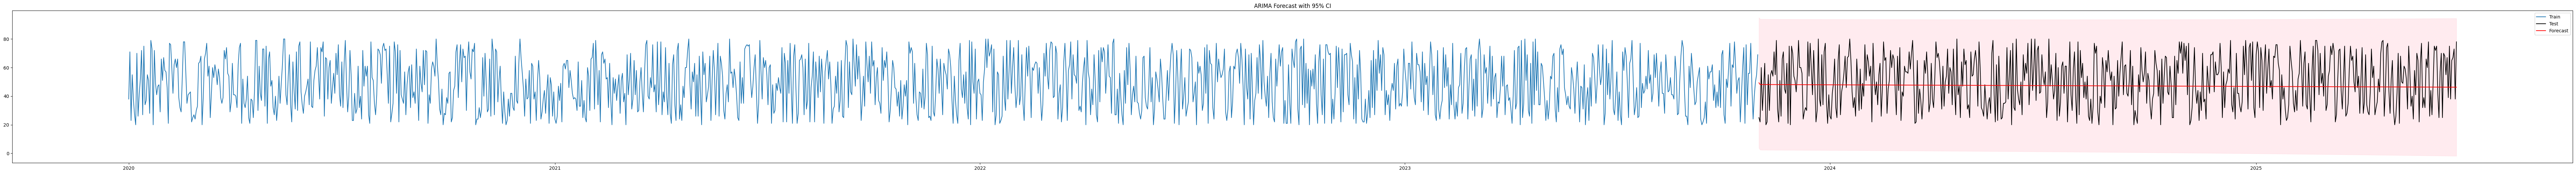

In [38]:
plt.figure(figsize=(100,6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test", color="black")
plt.plot(forecast.index, forecast, label="Forecast", color="red")
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color="pink", alpha=0.3)
plt.legend()
plt.title("ARIMA Forecast with 95% CI")
plt.show()

#### Evaluate

In [39]:
arima_rmse, arima_mae, arima_r2 = evaluate(test, forecast, name="ARIMA")

ARIMA: 
RMSE= 18.1661 
MAE= 15.8753 
R2= -0.0386


### LightGBM (RBCs_Issued)

#### Prepare data before fitting it into the model

In [40]:
X_train, X_test, y_train, y_test = prepare_data(df_fe, target, feature_cols)

#### Model and Fit

In [41]:
lightgbm_model = lgb.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.03,
    num_leaves=31,
    random_state=42
)

lightgbm_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="rmse"
)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2087
[LightGBM] [Info] Number of data points in the train set: 1400, number of used features: 22
[LightGBM] [Info] Start training from score 48.956429


LGBMRegressor(learning_rate=0.03, n_estimators=2000, random_state=42)

#### Prediction

In [42]:
y_pred = lightgbm_model.predict(X_test)

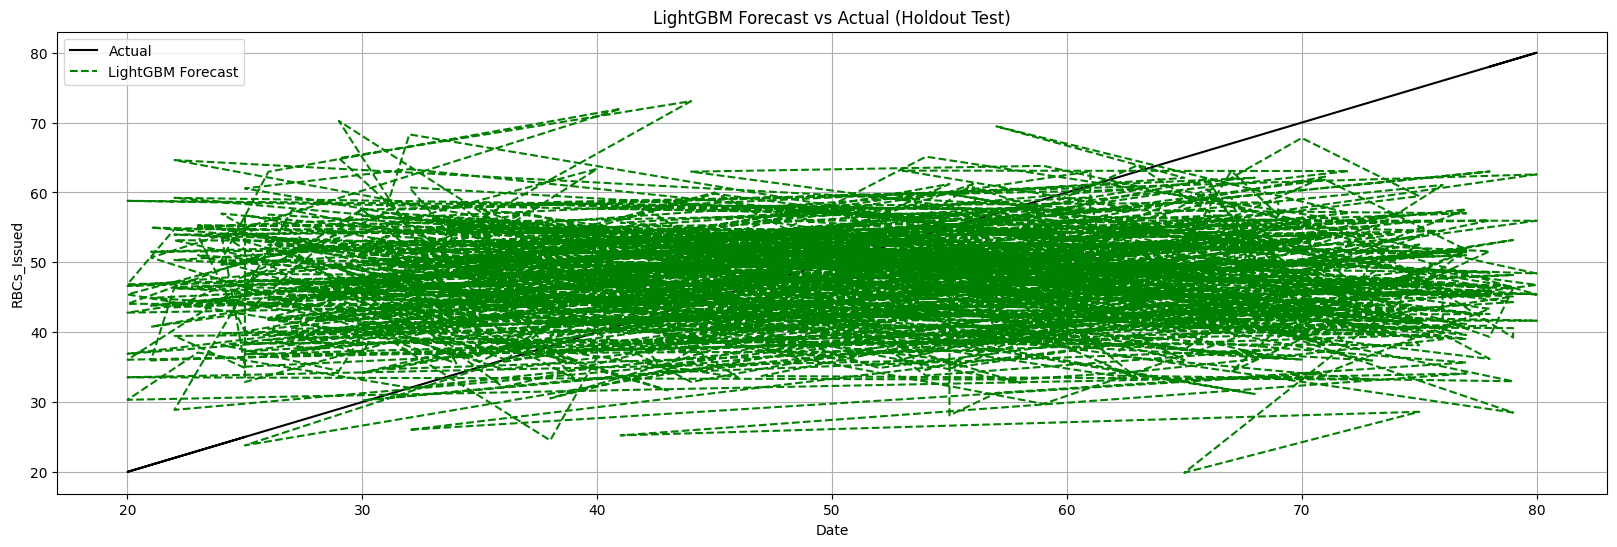

In [43]:
# ต้องแก้
plt.figure(figsize=(20,6))
plt.plot(y_test, y_test, label="Actual", color="black")
plt.plot(y_test, y_pred, label="LightGBM Forecast", color="green", linestyle="--")
plt.title("LightGBM Forecast vs Actual (Holdout Test)")
plt.xlabel("Date")
plt.ylabel(target)
plt.legend()
plt.grid(True)
plt.show()


#### Feature Importance

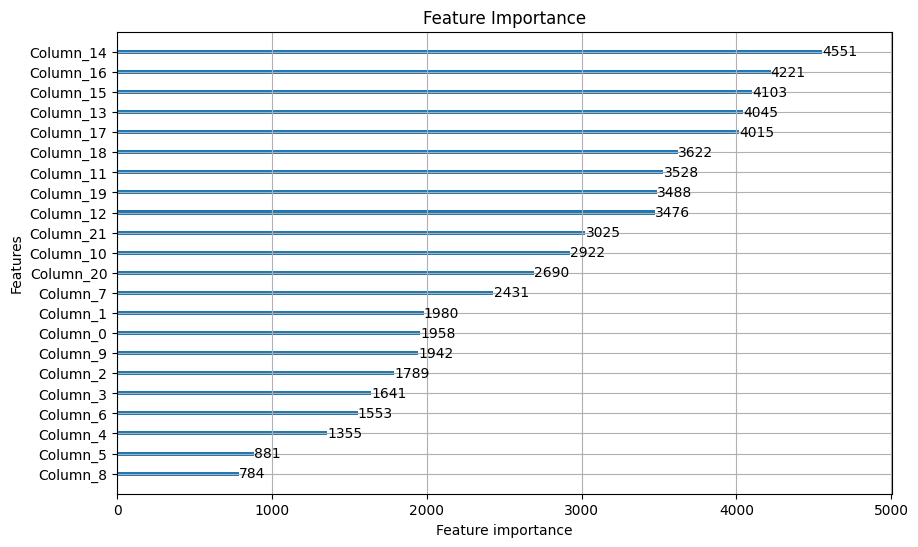

In [44]:
lgb.plot_importance(lightgbm_model, figsize=(10,6))
plt.title("Feature Importance")
plt.show()

#### Evaluate

In [45]:
lightgbm_rmse, lightgbm_mae, lightgbm_r2 = evaluate(y_test, y_pred, name="LightGBM")

LightGBM: 
RMSE= 19.5386 
MAE= 16.2047 
R2= -0.2015


### XGBoost (RBCs_Issued)

#### Prepare data before fitting it into the model

In [46]:
X_train, X_test, y_train, y_test = prepare_data(df_fe, target, feature_cols)

#### Model and Fit

In [47]:
xgboost_model = xgb.XGBRegressor(
    n_estimators=2000,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method="hist",      # ใช้ "gpu_hist" ถ้ามี GPU
    early_stopping_rounds=100,
    eval_metric="rmse"
)

xgboost_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=50
)

[0]	validation_0-rmse:17.87975
[50]	validation_0-rmse:17.99836
[100]	validation_0-rmse:18.07710
[112]	validation_0-rmse:18.10363


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=2000,
             n_jobs=None, num_parallel_tree=None, ...)

#### Predict

In [48]:
y_pred = xgboost_model.predict(X_test)

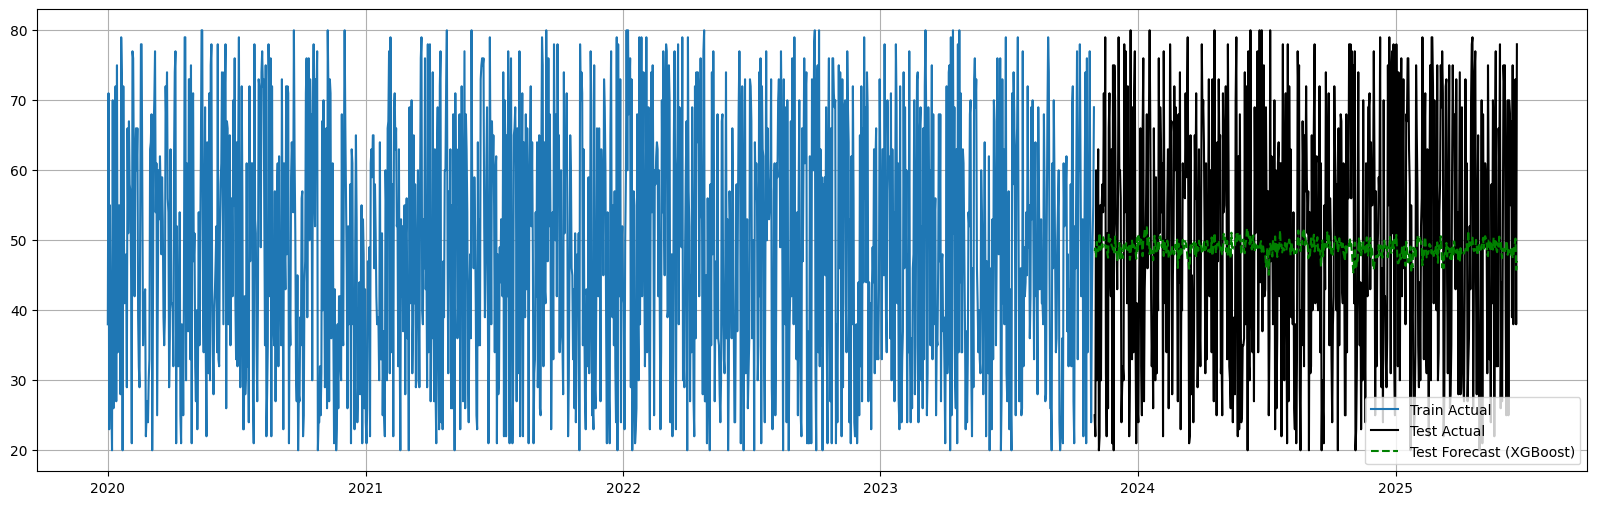

In [49]:
plt.figure(figsize=(20,6))
plt.plot(train.index, y_train, label="Train Actual")
plt.plot(test.index, y_test, label="Test Actual", color="black")
plt.plot(test.index, y_pred, label="Test Forecast (XGBoost)", color="green", linestyle="--")
plt.legend()
plt.grid(True)
plt.show()

#### Evaluate

In [50]:
xgboost_rmse, xgboost_mae, xgboost_r2 = evaluate(y_test, y_pred, name="XGBoost")

XGBoost: 
RMSE= 17.8711 
MAE= 15.6327 
R2= -0.0052


#### Feature Importance

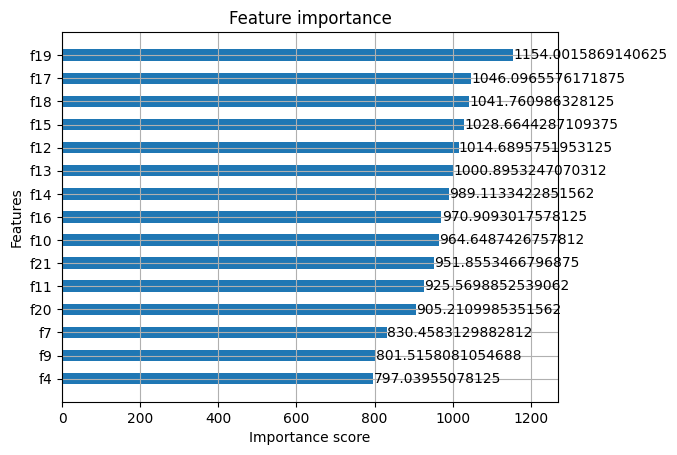

In [51]:
xgb.plot_importance(xgboost_model, importance_type="gain", max_num_features=15, height=0.5)
plt.show()

### Compare Model

In [52]:
copare_model = pd.DataFrame({
    "Model": ["Linear Regression", "ARIMA", "LightGBM", "XGBoost"],
    "RMSE": [linear_rmse, arima_rmse, lightgbm_rmse, xgboost_rmse],
    "MAE": [linear_mae, arima_mae, lightgbm_mae, xgboost_mae],
    "R2": [linear_r2, arima_r2, lightgbm_r2, xgboost_r2]
})

copare_model

,Model,RMSE,MAE,R2
0,Linear Regression,17.989993,15.752651,-0.018603
1,ARIMA,18.166126,15.875331,-0.038647
2,LightGBM,19.538646,16.204690,-0.201523
3,XGBoost,17.871061,15.632658,-0.005180


In [53]:
# Min RMSE
min_rmse_model = copare_model.loc[copare_model["RMSE"] == copare_model["RMSE"].min(), "Model"].values[0]
print(f"Min RMSE: {min_rmse_model}")

# Min MAE
min_mae_model = copare_model.loc[copare_model["MAE"] == copare_model["MAE"].min(), "Model"].values[0]
print(f"Min MAE: {min_mae_model}")

# Max R2
max_r2_model = copare_model.loc[copare_model["R2"] == copare_model["R2"].max(), "Model"].values[0]
print(f"Max R2: {max_r2_model}")

Min RMSE: XGBoost
Min MAE: XGBoost
Max R2: XGBoost


### Export Model

In [56]:
joblib.dump(linear_model, 'linear_model.pkl')
joblib.dump(arima_model, 'arima_model.pkl')
joblib.dump(lightgbm_model, 'lightgbm_model.pkl')
joblib.dump(xgboost_model, 'xgboost_model.pkl')

['xgboost_model.pkl']

## 9. Backtesting (rolling / expanding)

## 10. Metrics
* ประเมิน per-fold แล้วสรุป mean ± std


## 11. Uncertainty / Prediction intervals
* Quantile regression (LightGBM): ฝึกสอง/สามโมเดลสำหรับ q=0.1, 0.5, 0.9 → ได้ lower/median/upper prediction
* SARIMAX: มี get_forecast().conf_int()
* Bootstrap: resample residuals + add to prediction เพื่อสร้าง ensemble of forecasts

## 12. Explainability (feature importance)
* ใช้ SHAP กับ LightGBM เพื่อดูว่าฟีเจอร์ไหนสำคัญ (lags? ICU? total_surgeries?)

## 13. Ensembling & stacking
* Simple average of SARIMAX + LightGBM often improves robustness
* Weighted average based on CV MAE (weights ∝ 1/MAE)
* Stacking: สร้าง out-of-fold preds จาก base models → train meta model (e.g., Ridge)

## 14. Productionization (deploy & schedule)
* Save: joblib.dump(model, 'model.pkl') + save preprocessing pipeline (scaler, feature list)
* API: FastAPI skeleton for serving daily forecasts

## 15. Retraining policy & alerts
* Retrain schedule: weekly or monthly OR when MAE increases above threshold (e.g., 20% worse than baseline)
* Keep versioned models and a validation holdout to detect overfitting
* Alert if data ingestion fails or if coverage of PI < expected (e.g., 90% interval captures < 80% actuals)

## 16. Practical checklist & gotchas
* Exogenous vars for horizon: you must have future values (use forecasts of exog or features that are known ahead like calendar)
* Avoid leakage: never use target.shift(-k) in training features without correct alignment
* If data short (< 1 year): avoid complex seasonality models or deep nets; prefer simple models + robust CV
* If extreme spikes important: keep them in training (don’t clip) and consider flagged features to help model learn them


## 17. Minimal runnable pipeline (puttingทุกอย่างรวมกัน)
* ย่อ pipeline — เตรียม → features → train LightGBM 1-step → backtest (expanding)

## 18. Next actions (recommended, ordered)
	1.	ทำ EDA ให้ละเอียด (plot, STL, ACF) — บันทึกวิเคราะห์เป็น notebook
	2.	สร้าง lag + rolling + calendar features ตามตัวอย่างข้างต้น
	3.	ทำ baseline (naive / seasonal) และ SARIMAX สั้น ๆ (1-2 exog) เพื่อเก็บ reference
	4.	ทำ LightGBM (feature-based) + rolling CV (expanding window)
	5.	ทำ quantile models หรือ bootstrap for PI
	6.	SHAP เพื่ออธิบายผล และตรวจ feature importance
	7.	เลือกโมเดลสุดท้าย → serialize → deploy API → ตั้ง monitoring